# Project 3: Web APIs & NLP
## Reddit.com/r/workplacesitcoms 
#### By: Danielle Medellin [GitHub](https://github.com/dmedellin2)

## Table of Contents:
- [Problem Statement](#Problem-Statement)  
- [Executive Summary](#Executive-Summary)  
    - [Data Dictionary](#Data-Dictionary)
- [Data Import](#Data-Import)  
- [Data Cleaning](#Data-Cleaning)  
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Stop Words](#Looking-at-Top-100-Words-Overlap-to-Create-Stop-Words)
- [Modeling](#Modeling)
    - [Model Preparation](#Model-Preparation)
    - [Baseline Model](#Baseline-Model)
    - [Logistic Regression](#Logistic-Regression)
    - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
    - [k-Nearest Neighbors](#k-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree-(CART))
    - [Bagging Classifier](#Bagging-Classifier-(Bootstrap-Aggregating))
    - [Random Forest](#Random-Forest)
    - [Support Vector Machine](#Support-Vector-Machine)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Predictive Model](#Predictive-Model---Multinomial-Naive-Bayes)
    - [Interpretable Model](#Interpretable-Model---Logistic-Regression)
- [Conclusions and Recommendations](#Conclusions-&-Recommendations)
- [References](#References)

## Problem Statement 
[Top](#Table-of-Contents:)

NBC is looking to see how people engage with some of their most famous sitcoms on various social media platforms. One of these platforms is Reddit. An intern at NBC was tasked with gathering as many submissions as he could from subreddits for NBC sitcoms like _Will & Grace, The Office, Parks and Recreation, Brooklyn 99_, and _The Good Place_. Unfortunately, this intern was terrible at organization and dumped all of the posts he found into one general folder. NBC has been working to properly separate all of the submissions into their proper TV show groups. Most of the submissions were able to be separated, but two shows remain: _The Office_ and _Parks and Recreation_.  

It is so difficult to separate the posts between these two shows because they share a lot of similarities. For starters, they share some of the same creators including Greg Daniels and Michael Schur. Both shows are considered workplace comedies as they take place at either a paper company or a government office. While both shows started and ended in different years, they had many years of overlap where both were actively on the air. Additionally, the two shows share some character names and even an actor! For example, both shows include a character named 'Andy' and Rashida Jones played a consistent role in both TV shows. Looking at crossover between character names and actor names, we get even more commonalities, for example the character 'Michael Scott' from _The Office_ and the actor Adam Scott, who plays a main role in _Parks and Recreation_.  

Due to the many similarities between these two shows, NBC came to us to help them sort through the posts and separate them back into their appropriate subreddits: _The Office_ -- r/DunderMifflin, and _Parks and Recreation_ -- r/PandR.  

Additionally, NBC is also interested in what content helped made it possible to differentiate between the two shows and what Reddit users are talking about the most in each of the subreddits.  

We will build a classification model that will help to sort each post to its appropriate subreddit. Our model's success will be measured with an accuracy score.

## Executive Summary
[Top](#Table-of-Contents:)

Blah blah blahdhslkf

### Data Dictionary


|Feature|Type|Description|
|:---|:---:|:---|
|title|object|The title of the Reddit submission|
|selftext|object|Additional text about the post (optional)|
|subreddit|int|A 0 indicates r/DunderMiffilin, a 1 indicates r/PandR|
|author|object|Username of submission author|
|num_comments|int|Number of comments on that submission|
|score|int|A submission's score is the number of upvotes minus the number of downvotes|
|timestamp|datetime|The date of submission|




The data: 
What is the score?   https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F

## Data Import
[Top](#Table-of-Contents:)  
In the _data_gathering_ notebook, one can view the process for using the reddit API to collect posts from the r/DunderMifflin and r/PandR subreddits over the course of the past 10 years. Both subreddits were created in January of 2011.

### Importing Libraries
[Top](#Table-of-Contents:)

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS as stopwords
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.base import TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.svm import SVC


#import warnings
# warnings.filterwarnings("ignore") 

In [2]:
# read in the data
reddit = pd.read_csv('../data/reddit.csv')
reddit.drop(columns=['created_utc','is_self'],inplace=True)

In [3]:
# check dataframe
reddit.head(2)

,title,selftext,subreddit,author,num_comments,score,timestamp
0,Letter to Brendanawicz,This guy had no chance. He started out being c...,PandR,RandySwango,4,18,2019-10-17
1,Just started watching the show on Amazon Prime...,At least on season two as I've noticed the sub...,PandR,Oo00oOo00oOO,0,1,2019-10-17


## Data Cleaning
[Top](#Table-of-Contents:)

In [4]:
# check the shape of the data
reddit.shape

(4675, 7)

Our `reddit` dataframe includes 4675 reddit posts, each with 7 features.

In [5]:
# checking for null values
reddit.isnull().sum()

title             0
selftext        570
subreddit         0
author            0
num_comments      0
score             0
timestamp         0
dtype: int64

The only column with null values is the `selftext` column, which we will not be using in analysis. For text analysis, we will focus on the title column only.

In [6]:
reddit.dtypes

title           object
selftext        object
subreddit       object
author          object
num_comments     int64
score            int64
timestamp       object
dtype: object

Being most of our data in the dataframe is text, most data types should be 'object'. We will convert the `timestamp` column into datetime. Currently, the `subreddit` column has the name of the subreddit the submission came from, but we will turn that into a binary classification where 0 means r/DunderMifflin (_The Office_) and 1 means r/PandR (_Parks and Recreation_).

In [7]:
reddit['subreddit'].value_counts()

DunderMifflin    2626
PandR            2049
Name: subreddit, dtype: int64

In [8]:
# casting subreddit as 0,1 0 = Office, 1 = P and R
reddit['subreddit'] = [1 if entry == 'PandR' else 0 for entry in reddit['subreddit']]

In [9]:
# confirming value counts
reddit['subreddit'].value_counts()

0    2626
1    2049
Name: subreddit, dtype: int64

In [10]:
# changing timestamp to a datetime object
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'])

In [11]:
reddit.dtypes

title                   object
selftext                object
subreddit                int64
author                  object
num_comments             int64
score                    int64
timestamp       datetime64[ns]
dtype: object

In [12]:
reddit.describe()

,subreddit,num_comments,score
count,4675.000000,4675.000000,4675.000000
mean,0.438289,7.761711,17.507594
std,0.496230,21.852437,338.446323
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,4.000000,4.000000
75%,1.000000,9.000000,10.000000
max,1.000000,1180.000000,22726.000000


Statistics for the `subreddit` column make sense as the max is 1 and the min is 0. Looking at the quartlies and maximum for the `num_comments` column, it appears that there may be outliers in the data since the maximum is so far from the 75th percentile. Similarly, for the `score` column, the range from the minimum to the 75th percentile is 0 - 10, but the jump from the 75th percentile to the maximum is much greater with a maximum of 22726. Again, this shows that there may be outliers in the data. 

In [13]:
reddit.groupby('subreddit').describe().T

subreddit                      0            1
num_comments count   2626.000000  2049.000000
             mean       9.064356     6.092240
             std       27.013042    12.230085
             min        0.000000     0.000000
             25%        2.000000     1.000000
             50%        5.000000     3.000000
             75%       10.000000     7.000000
             max     1180.000000   229.000000
score        count   2626.000000  2049.000000
             mean      19.471059    14.991215
             std      448.979861    55.062774
             min        0.000000     0.000000
             25%        1.000000     1.000000
             50%        3.000000     4.000000
             75%        9.000000    11.000000
             max    22726.000000  1105.000000

Separating the data by subreddit, we can see that the r/DunderMifflin subreddit has higher maximums for both the `score` and `num_comments` columns. 

In [14]:
# sorting df by `num_comments`
reddit.sort_values('num_comments', ascending=False).head()

,title,selftext,subreddit,author,num_comments,score,timestamp
2373,The day they take The Office off of Netflix is...,NaN,0,RonThunderfist,1180,22726,2018-04-26
4195,"SO9EO9 ""Dwight Christmas"" Episode Discussion","From Wikipedia: \n\n""When the party planning c...",0,Prefer_an_astronaut,253,55,2012-12-06
4173,"SO9EO8 ""The Target"" Discussion Thread","From Wikipedia:\n\n""Angela goes to Dwight for ...",0,Prefer_an_astronaut,236,56,2012-11-29
1521,"Parks And Recreation S06E08/09 ""Fluoride"" / ""T...",####Two new episodes again tonight! \n\n\n---\...,1,atticus138,229,111,2013-11-21
863,Has anyone found another comedy that gives the...,The only one was the office. I felt attached t...,1,andrew9360,210,185,2016-06-14


After visually exploring the data a bit, we see there is an outlier in the `num_comments` column. We will drop the row with 1180 comments.

In [15]:
reddit.drop([2373],inplace=True)

In [16]:
# sorting df by `score`
reddit.sort_values('score', ascending=False).head()

,title,selftext,subreddit,author,num_comments,score,timestamp
3605,Found the best way to watch The Office,First make sure you have enough time to watch ...,0,Dan_Ashcroft,90,2540,2014-11-19
3083,"It is me, Rainn Wilson (that guy from The Offi...",At 1pm (PDT) I’ll be on the @SoulPancake snapc...,0,IAmRainnWilson,105,2419,2016-05-19
1382,Why Jerry is without a doubt the best characte...,"lol jk, you're the worst Jerry!",1,radslacker,100,1105,2014-12-30
769,"I can never, ever read ""treat yoself"" or ""trea...","And yes, I have treated myself more.",1,geetannn,37,840,2016-12-29
964,"Just realized that Leslie, Ann, &amp; Tom all ...",I'm sure someone else has already pointed this...,1,MooCow93,51,748,2016-07-30


After visually exploring the data a bit, we see there are some outliers in the `score` column. We will drop the rows with scores of more than 2000.

In [17]:
reddit = reddit[reddit['score']<2000]

## Exploratory Data Analysis
[Top](#Table-of-Contents:)

In [18]:
# function for creating boxplots
def new_boxplot(data,x,y,title,xlabel,ylabel,palette):
    plt.figure(figsize=(7,6))
    sns.boxplot(data=data, x=y, y=x, palette=palette)
    plt.title(title,size=15)
    plt.xlabel(xlabel,size=12)
    plt.ylabel(ylabel,size=12);

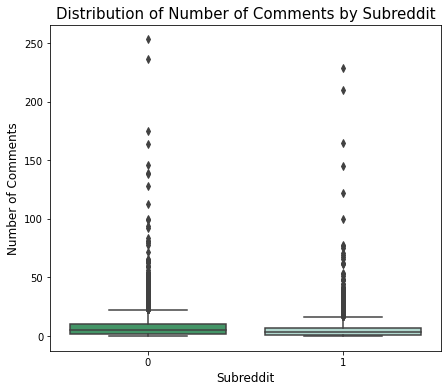

In [19]:
new_boxplot(reddit, 'num_comments','subreddit','Distribution of Number of Comments by Subreddit','Subreddit','Number of Comments','BuGn_r')

The majority of the data for both subreddits has less than 25 comments per post. The maximum amount of comments for both subreddits reaches around 230-250. Both subreddits have similar distributions, but the quartiles and maximum for _The Office_ (0) subreddit are generally higher than those of the _Parks and Recreation_ (1) subreddit. Given the similarities in the distributions, it is unclear if the number of comments per post will be a helpful predictive feature in our model.

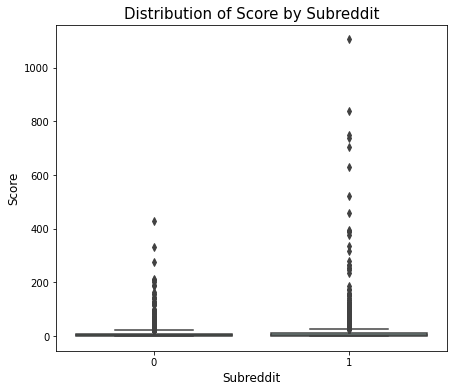

In [20]:
new_boxplot(reddit, 'score','subreddit','Distribution of Score by Subreddit','Subreddit','Score','BuGn_r')

The majority of the scores of posts for both subreddits is from 0-30. Both subreddits have scores that fall outside that range. The maximum for _The Office_ (0) subreddit falling around 450, and the maximum for the _Parks and Recretaion_ (1) subreddit falling beyond 1000. There are many more posts with scores of 200 or more for the _Parks and Recreation_ subreddit as opposed to _The Office_ subreddit. Looking at the Score for each post might be a helpful predictive feature in the model. 

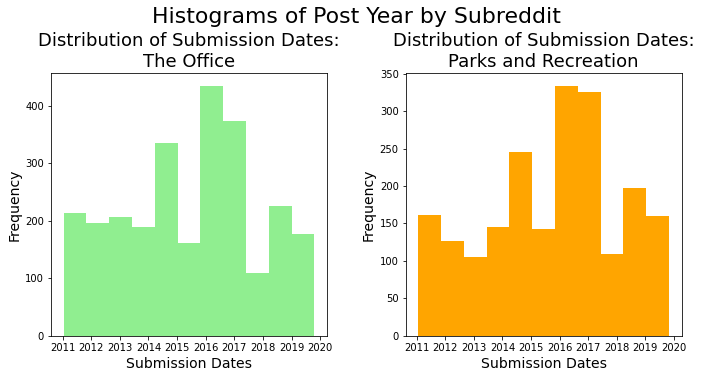

In [21]:
cols = [0,1] # diff subreddits 

fig, axes = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)

fig.suptitle("Histograms of Post Year by Subreddit", fontsize = 22, y = 1.04)

axes = axes.flatten()

color = ['lightgreen', 'orange']

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(reddit[reddit['subreddit']==col]['timestamp'],color=color[i],bins=11)
    ax.set_ylabel("Frequency",size=14)
    readable_col = ['The Office','Parks and Recreation']
    ax.set_xlabel('Submission Dates',size=14)
    ax.set_title(f"Distribution of Submission Dates:\n{readable_col[i]}",size=18)
    
plt.tight_layout();

We pulled data in intervals of every 6 months for the past 10 years from both subreddits. Both of these subreddits began in January of 2011. The two subreddits have similar distributions with peaks around 2016-2017. These are years that both of the shows were already off air. Neither subreddit seems to fall below 100 posts in a specific time range. Surprisingly, the most recent time range has a similar amount of posts as the first time range. Both subreddits show a similar distribution meaning using the `timestamp` feature might not be useful for our model. 

In [22]:
# creating count vectorizer to look at frequent words
cvec = CountVectorizer()
X_text = reddit['title'] # grabbing just the titles 

In [23]:
# count vectorizing and put in dataframe
X_text = cvec.fit_transform(X_text)
X_text_df = pd.DataFrame(X_text.toarray(), columns = cvec.get_feature_names())

In [24]:
# grabbing top 30 most common words
top_words = X_text_df.sum().sort_values(ascending=False)[:30]

In [25]:
top_words

the        2346
and         847
to          838
is          750
of          727
in          677
what        496
you         447
season      414
episode     412
office      402
for         396
that        388
just        370
it          337
on          315
this        278
show        274
was         273
anyone      271
have        260
michael     254
with        231
from        219
my          218
how         207
does        205
about       204
do          194
can         193
dtype: int64

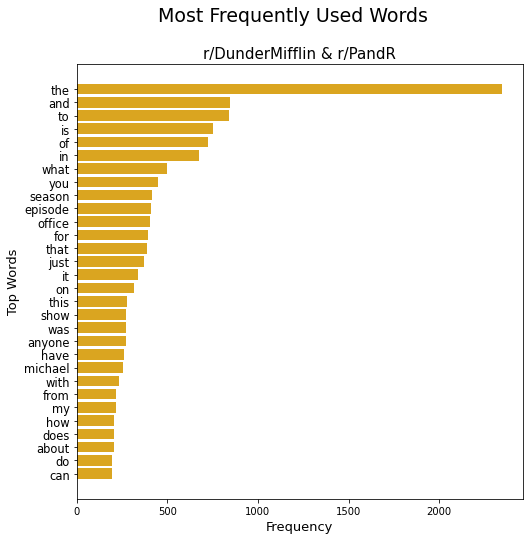

In [26]:
plt.figure(figsize=(8,8))
plt.barh(y=top_words.index[::-1],width=top_words[::-1],color='goldenrod')
plt.suptitle('Most Frequently Used Words',size=19)
plt.title('r/DunderMifflin & r/PandR',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Top Words',size=13)
plt.yticks(size=11.5);

Above are the top 30 most frequently used words found in both subreddits combined. Most of these words are general filler words that do not give us much meaning like `the`, `of`, and `with`. Some of them make sense given that our two subreddits are focused on television shows, like `episode`, `show`, and `season`. Only two of these words stick out to us as being possibly important words that could help determine which subreddit a post is from: `office` and `michael`. The reason for that is because the r/DunderMifflin subreddit is about the show _The Office_ and the main character of that show is Michael Scott. Given these facts it is expected that the words `office` and `michael` would show up frequently in the posts of that subreddit. 

In [27]:
# creating list of possible stop words
poss_stopwords = list(top_words.index)

In [28]:
poss_stopwords.remove('michael')

In [29]:
poss_stopwords.remove('office')

In [30]:
print(len(poss_stopwords))
poss_stopwords

28


['the',
 'and',
 'to',
 'is',
 'of',
 'in',
 'what',
 'you',
 'season',
 'episode',
 'for',
 'that',
 'just',
 'it',
 'on',
 'this',
 'show',
 'was',
 'anyone',
 'have',
 'with',
 'from',
 'my',
 'how',
 'does',
 'about',
 'do',
 'can']

We have taken the list of the top 30 most frequent words from above, removed `michael` and `office`, and kept it as a list of possible stop words. When creating our model later, we will want to focus on the most frequently used words. If the majority of our most frequently used words are words like `the`, `for`, and `can`, our model will not be great at classifiying the posts into the correct subreddit. Thus, we will test the use of this list as our list of stop words in our models later. 

In [31]:
# get text from just the office subreddit
off_text = reddit[reddit['subreddit']==0]['title']

In [32]:
# count vectorize office text
cvec = CountVectorizer()
off_text = cvec.fit_transform(off_text)
off_text_df = pd.DataFrame(off_text.toarray(), columns = cvec.get_feature_names())

In [33]:
# get text from just parks and rec subreddit
parks_text = reddit[reddit['subreddit']==1]['title']

In [34]:
# count vectorize parks and rec subreddit 
cvec = CountVectorizer()
parks_text = cvec.fit_transform(parks_text)
parks_text_df = pd.DataFrame(parks_text.toarray(), columns = cvec.get_feature_names())

In [35]:
# top 30 most frequent words in office subreddit
off_top = off_text_df.sum().sort_values(ascending=False)[:30]

In [36]:
# top 30 most frequent words in parks and rec subreddit
parks_top = parks_text_df.sum().sort_values(ascending=False)[:30]

In [37]:
# looking at the overlap in the top 30 of each individual subreddit 
overlap = set(off_top.index).intersection(set(parks_top.index))
print(len(overlap))
overlap

21


{'and',
 'anyone',
 'episode',
 'for',
 'have',
 'in',
 'is',
 'it',
 'just',
 'of',
 'on',
 'season',
 'show',
 'that',
 'the',
 'this',
 'to',
 'was',
 'what',
 'with',
 'you'}

We looked at the top 30 most frequently occurring words in the titles of submissions from each subreddits individually. After looking at the intersection of those two sets of words, it was found that 21 words were shared by both subreddits. Most of these words are 'filler' words like `for`, `just`, `and`, `that`, and `the` which don't give us much information. Words that make sense for these subreddits are `show`, `epsiode` and `season`, but because both subreddits are focused on television shows, they don't help to distinguish between the two.  


In [38]:
# finding words that are only in the parks top 30
parks_only = set(parks_top.index) - set(off_top.index)
parks_only

{'can', 'does', 'how', 'leslie', 'me', 'my', 'parks', 'rec', 'ron'}

In [39]:
# finding words that are only in the office top 30
off_only = set(off_top.index) - set(parks_top.index)
off_only

{'about', 'do', 'dwight', 'from', 'jim', 'michael', 'office', 'pam', 'your'}

In [40]:
# getting frequency for just the unique office words
off_top_words = off_text_df[off_only].sum().sort_values(ascending=False)[:30]

In [41]:
# # getting frequency for just the unique parks and rec words
parks_top_words = parks_text_df[parks_only].sum().sort_values(ascending=False)[:30]

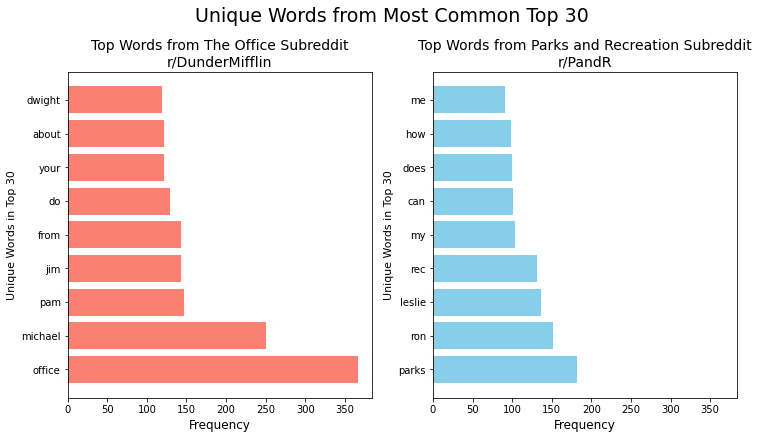

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6), sharex=True) # unpack graphs
# add title to entire figure
fig.suptitle("Unique Words from Most Common Top 30", fontsize = 19, y = 1.03) 

ax1.barh(y=off_top_words.index,width=off_top_words,color='salmon') 
ax2.barh(y=parks_top_words.index,width=parks_top_words,color='skyblue')
ax1.set_title('Top Words from The Office Subreddit\nr/DunderMifflin',size=14)
ax2.set_title('Top Words from Parks and Recreation Subreddit\nr/PandR',size=14)
ax1.set_xlabel('Frequency',size=12)
ax2.set_xlabel('Frequency',size=12)
ax1.set_ylabel('Unique Words in Top 30', size=11)
ax2.set_ylabel('Unique Words in Top 30', size=11);

We looked at the top 30 most frequently occurring words in the titles of both subreddits. After looking at the intersection of those two sets of words, it was found that 21 of those words were shared by both subreddits. 

We separated out the **unique** words for each subreddit's top 30 and plotted their frequencies above. Still there are some words that don't give us much information such as `your`, `do`, `from`, `my`, `can`, and `how`, but we also notice some other words that stand out. For the _The Office_ subreddit some of the top words include `office`, `michael`, `pam`, `jim`, and `dwight`. While `office` may seem like a mundane word, it is very important for the r/DunderMifflin subreddit because it is the name of the show that the subreddit is focused on, _The Office_! Additionally, four of the main characters of the show are Jim, Michael, Pam, and Dwight, so these are definitely bound to pop up in r/DunderMifflin posts more often than the other subreddit.  

Similarly, for r/PandR, which focuses on the show _Parks and Recreation_ (often abbreviated as _Parks and Rec_), two of the most popular words are `parks` and `rec`. The second and third most popular unique words are `ron` and `leslie`, which are two main characters of the TV show. It makes sense that these two words would show up often in posts from r/PandR. 

### Looking at Top 100 Words Overlap to Create Stop Words
[Top](#Table-of-Contents:)

In [43]:
# top 100 words in office subreddit
off_top_100 = off_text_df.sum().sort_values(ascending=False)[:100]

In [44]:
# top 100 words in parks and rec subreddit
parks_top_100 = parks_text_df.sum().sort_values(ascending=False)[:100]

In [45]:
# overlap of top 100 from both
overlap_100 = list(set(parks_top_100.index).intersection(set(off_top_100.index)))

In [46]:
# how many in overlap?
len(overlap_100)
overlap_100

['they',
 'question',
 'get',
 'when',
 'in',
 'watching',
 'have',
 'why',
 'it',
 'the',
 'on',
 'help',
 'think',
 'season',
 'andy',
 'how',
 'an',
 'know',
 'about',
 'not',
 'favorite',
 'be',
 'with',
 'first',
 'did',
 'like',
 'really',
 'episodes',
 'this',
 'show',
 'series',
 'was',
 'there',
 'me',
 'at',
 'my',
 'watch',
 'something',
 'character',
 'finished',
 'that',
 'from',
 'to',
 'do',
 'for',
 'who',
 'out',
 'anyone',
 'of',
 'and',
 'are',
 'where',
 'as',
 'after',
 'one',
 'best',
 'or',
 'can',
 'does',
 'but',
 'up',
 'time',
 'you',
 'else',
 'would',
 'is',
 'office',
 'what',
 'we',
 'episode',
 'if',
 'your',
 'just',
 'he',
 'all',
 'has',
 'so']

We looked at the top 100 words for both individual subreddits and then looked at just the overlap between the two lists of top words. There were 77 words in both lists. After looking through this list, there are some words that can be helpful in determining which subreddit the post belongs to. The word `andy` is interesting because there is a character named Andy in both _The Office_ and _Parks and Recreation_. We will keep this word in our model because it's association with other words could help the model classify the posts. The word `office` comes up again and, like we stated above, this word will be kept because it is in the title of one of the shows we are discussing. The rest of the words have no true association with either one of the shows so they will be included in our stop words list.

In [47]:
poss_stopwords = overlap_100

In [48]:
poss_stopwords.remove('office')

In [49]:
poss_stopwords.remove('andy')

We have created a list of stop words from this overlap. Below in our models, we will test this list of stop words to see if removing these words from the model helps to classify our posts correctly. First, we will investigate more thoroughly to add more stop words to the list.

In [97]:
# creating count vectorizer to look at frequent words while using stopwords
cvec_stop = CountVectorizer(stop_words='english')
X_text_stop = reddit['title'] # grabbing just the titles 

In [99]:
# count vectorizing and put in dataframe
X_text_stop = cvec_stop.fit_transform(X_text_stop)
X_text_df_stop = pd.DataFrame(X_text_stop.toarray(), columns = cvec_stop.get_feature_names())

In [124]:
top_words_stop_100 = X_text_df_stop.sum().sort_values(ascending=False)[50:100]
top_words_stop_100

seasons       57
song          55
tom           55
don           55
quote         54
jerry         54
little        51
want          51
creed         50
people        50
characters    50
say           50
feel          50
guys          49
discussion    49
good          48
day           48
ann           48
scranton      48
ryan          47
got           45
pawnee        45
started       43
end           43
happened      42
life          42
said          40
anybody       40
favourite     39
going         39
thing         39
didn          39
actually      39
recreation    38
night         38
pandr         38
thread        36
clip          36
mark          36
real          36
better        35
angela        35
dunder        35
video         35
christmas     34
thought       34
moments       34
request       33
way           33
post          33
dtype: int64

In [125]:
set(top_words_stop_100.index) - set(poss_stopwords)

{'actually',
 'angela',
 'ann',
 'anybody',
 'better',
 'characters',
 'christmas',
 'clip',
 'creed',
 'day',
 'didn',
 'discussion',
 'don',
 'dunder',
 'end',
 'favourite',
 'feel',
 'going',
 'good',
 'got',
 'guys',
 'happened',
 'jerry',
 'life',
 'little',
 'mark',
 'moments',
 'night',
 'pandr',
 'pawnee',
 'people',
 'post',
 'quote',
 'real',
 'recreation',
 'request',
 'ryan',
 'said',
 'say',
 'scranton',
 'seasons',
 'song',
 'started',
 'thing',
 'thought',
 'thread',
 'tom',
 'video',
 'want',
 'way'}

In [126]:
new_stops = ['amp','finale','looking','love','make','moment','need','netflix','new','noticed','scene','spoilers','ve','watched','actually','anybody','better','characters','clip','didn','discussion','don','end','favourite','feel','going','good','got','guys','happened','moments','post','quote','real','request','said','say','seasons','started','thing','thought','thread','video','want','way']

In [127]:
len(new_stops)

45

We ran a CountVectorizer with the 'english' stop words library used by `sklearn`. We then looked at the new top 100 words in both subreddits combined. We combed through these words and took out any words that didn't seem to have an association with either show. Many of the words that remained were names of characters or locations where the shows take place. Some additional words that were kept despite seeming random were `christmas`, `little`, and `day`. The reasons for these are because in _The Office_ they have a lot of Christmas episodes that are pretty notorious in the fandom. _The Office_ also has an entire episode focused on 'Pretzel Day', so this might be discussed in the r/DunderMifflin subreddit. Lastly, `little` was kept because there is a character in _Parks and Recreation_ who is a small horse and his name is Little Sebastian. Any mention of Little Sebastian in a submission is likely to be a part of the r/PandR subreddit. 

This is our final list of stop words that will be used in the models. 

In [179]:
# loading in CountVec stop words
stopwords_eng = stopwords.words('english')

In [180]:
len(stopwords_eng)

179

In [190]:
# combining two stop words lists 
cust_stopwords = set(poss_stopwords).union(set(new_stops))
cust_stopwords = cust_stopwords.union(set(stopwords_eng))
cust_stopwords = list(cust_stopwords)
len(cust_stopwords)

246

We created a custom list of stop words including the original 'english' stop words list from `sklearn`, the overlapping irrelevant words from the top 100 of both subreddits, and additional words from the top 100 words overall of the whole data set with stopwords removed. This list, `cust_stopwords`, was pushed through the model as an option for a stop words list. In all of our models, though, the regular `english` stop words list was preferred.

## Modeling
[Top](#Table-of-Contents:)

For our models, the features we will be using are the text (words) of the titles of the submissions from the subreddits. We will use a Count Vectorizer or Tfidf Vectorizer to count the frequencies of these words in each submission title. We tested out using additional features such as `score` and `num_comments`, but those models were not as successful at classifying the data as the models below with strictly text data.  

### Model Preparation

In [196]:
# setting X & y, train test split
X = reddit['title']
y = reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

We tested out using `PorterStemmer()` on our text data in an attempt to find more matches of words within the data. Our models using the stemmer were not as successful at classifying the data as the models below that did not use the stemmer.

### Baseline Model
[Top](#Table-of-Contents:)

In [197]:
# find proportion of y train
y_train.value_counts(normalize=True)

0    0.561358
1    0.438642
Name: subreddit, dtype: float64

In [198]:
# find proportion of y test
y_test.value_counts(normalize=True)

0    0.561644
1    0.438356
Name: subreddit, dtype: float64

Our baseline model would be one that predicts the majority class for every entry. If we did this, the model would perform with 56.2% accuracy, correctly predicting all of the entries from _The Office_ subreddit (r/DunderMifflin). We are looking to make a model that performs better than the baseline model.

### Logistic Regression
[Top](#Table-of-Contents:)

In [199]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(C=5))])

# construct paramters
params = {'vec__max_features':[800, 1000],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2,3],
         'vec__max_df'       :[.90],
          'vec__stop_words'  :[None, 'english', cust_stopwords],
          'tfidf__use_idf'   :[True,False]}

 # Perform Grid Search
gs = GridSearchCV(pipe, 
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
logreg = gs.fit(X_train, y_train)

In [200]:
logreg_train = logreg.score(X_train, y_train)
logreg_test = logreg.score(X_test, y_test)
logreg_cv = cross_val_score(logreg.best_estimator_, X, y).mean()
logreg.best_params_

{'tfidf__use_idf': True,
 'vec__max_df': 0.9,
 'vec__max_features': 1000,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': 'english'}

In [201]:
print(f'Logistic Regression:')
print(f'Train Accuracy: {logreg_train}')
print(f'Test Accuracy: {logreg_test}')
print(f'Cross Val Accuracy: {logreg_cv}')
print(f'Difference (Train - Test): {logreg_train - logreg_test}')

Logistic Regression:
Train Accuracy: 0.896689497716895
Test Accuracy: 0.7988013698630136
Cross Val Accuracy: 0.7945259879306988
Difference (Train - Test): 0.09788812785388135


Our logistic regression model is performing with a train accuracy score of 89.7% and a test accuracy score of 79.9%. The higher train score indicates that there is some overfitting in the model, but the model is still performing decently on unseen data. After a lot of exploration, it was found that the logistic regression model works best when using TF-IDF and using the given 'english' stop words list. 

### Multinomial Naive Bayes
[Top](#Table-of-Contents:)

In [202]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())])

# construct paramters
params = {'vec__max_features':[800, 1000],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :[None, 'english', cust_stopwords],
          'tfidf__use_idf'   :[True,False]}

 # Perform Grid Search
gs = GridSearchCV(pipe, 
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
mnb = gs.fit(X_train, y_train)

In [203]:
mnb_train = mnb.score(X_train, y_train)
mnb_test = mnb.score(X_test, y_test)
mnb_cv = cross_val_score(mnb.best_estimator_, X, y).mean()
mnb.best_params_

{'tfidf__use_idf': False,
 'vec__max_features': 1000,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [204]:
print(f'Multinomial Naive Bayes:')
print(f'Train Accuracy: {mnb_train}')
print(f'Test Accuracy: {mnb_test}')
print(f'Cross Val Accuracy: {mnb_cv}')
print(f'Difference (Train - Test): {mnb_train - mnb_test}')

Multinomial Naive Bayes:
Train Accuracy: 0.8547374429223744
Test Accuracy: 0.7902397260273972
Cross Val Accuracy: 0.7917431780966231
Difference (Train - Test): 0.06449771689497719


Naive Bayes is a classification technique that relies on probability to classify observations. It is based on the probability rule _Bayes' Theorem_.  

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

In our model, we are calculating the probability of a submission coming from one of two subreddits, given the words found in the title of that submission. Specifically, Multinomial Naive Bayes works well with integers, but can also work with fractions (like data from TF-IDF).  
Our best Multinomial Naive Bayes model did not use TF-IDF and looked at only words of n-gram = 1 (one word at a time). Its training accuracy score is 85.5% and its testing accuracy score is 79%. While the testing score of this model is slightly lower than that of the Logistic Regression model (79.9%), the difference between the training and testing scores in this model is smaller, indicating there is less overfitting in this model. 


### _k_-Nearest Neighbors
[Top](#Table-of-Contents:)

In [65]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier())])

# construct paramters
params = {'vec__max_features':[200, 300, 400],
         'vec__ngram_range'  :[(1,1),(1,2), (2,2)],
         'vec__min_df'       :[2, 3],
          'tfidf__use_idf'   :[True,False],
         'knn__n_neighbors'  :[4, 5, 6]}

 # Perform Grid Search
gs = GridSearchCV(pipe, 
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
knn = gs.fit(X_train, y_train)

In [142]:
knn_train = knn.score(X_train, y_train)
knn_test = knn.score(X_test, y_test)
knn_cv = cross_val_score(knn.best_estimator_, X, y).mean()
knn.best_params_

{'knn__n_neighbors': 6,
 'tfidf__use_idf': False,
 'vec__max_features': 300,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 2)}

In [145]:
print(f'k-Nearest Neighbors:')
print(f'Train Accuracy: {knn_train}')
print(f'Test Accuracy: {knn_test}')
print(f'Cross Val Accuracy: {knn_cv}')
print(f'Difference (Train - Test): {knn_train - knn_test}')

k-Nearest Neighbors:
Train Accuracy: 0.7856735159817352
Test Accuracy: 0.7157534246575342
Cross Val Accuracy: 0.6885749292903846
Difference (Train - Test): 0.06992009132420096


The k-Nearest Neighbors model find the _k_ closest neighbors to the data point and classifies that entry as whatever the majority class of the neighbors is. It is interesting to note that our kNN model preferred much less features than the two previous models (Logistic Regression & Multinomial Naive Bayes). The training accuracy score for the kNN model is 79.2% and the testing accuracy score is 70.5%. While the difference between these two scores falls between our Logistic Regression & Multinomial Naive Bayes models, the testing score is much lower than both of the previously mentioned models. 

### Decision Tree (CART)
[Top](#Table-of-Contents:)

In [71]:
tree = DecisionTreeClassifier(random_state=42)


In [205]:
# takes awhile to run 
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('tree', DecisionTreeClassifier(random_state=42))])

# construct paramters
params = {'vec__max_features':[300, 400, 500],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :['english', cust_stopwords],
          'tfidf__use_idf'   :[True,False],
         'tree__max_depth'   :[70,80,100],
         'tree__max_features':['auto', 50, 60]}

 # Perform Grid Search
gs = GridSearchCV(pipe, 
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
tree = gs.fit(X_train, y_train)

CPU times: user 2min 24s, sys: 808 ms, total: 2min 25s
Wall time: 2min 27s


In [206]:
tree_train = tree.score(X_train, y_train)
tree_test = tree.score(X_test, y_test)
tree_cv = cross_val_score(tree.best_estimator_, X, y).mean()
tree.best_params_

{'tfidf__use_idf': False,
 'tree__max_depth': 100,
 'tree__max_features': 60,
 'vec__max_features': 500,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [207]:
print(f'Decision Tree:')
print(f'Train Accuracy: {tree_train}')
print(f'Test Accuracy: {tree_test}')
print(f'Cross Val Accuracy: {tree_cv}')
print(f'Difference (Train - Test): {tree_train - tree_test}')

Decision Tree:
Train Accuracy: 0.8590182648401826
Test Accuracy: 0.7722602739726028
Cross Val Accuracy: 0.7622075141132957
Difference (Train - Test): 0.08675799086757985


A decision tree classifies our submissions by splitting the data into subsets based on their values for specific features. The decision tree will try to find the "best" way to split the data, looking for maximum information gain with each split. Our Decision Tree classifier has a training accuracy score of 85.9% and a testing accuracy score of 77.2%. This model is performing okay compared to the other models we've looked at, but there is still overfitting as the train score is larger than the test score. In an effort to decrease the amount of overfitting, we will trade some variance for bias and move onto the next classifier: bagging.

### Bagging Classifier (Bootstrap Aggregating)
[Top](#Table-of-Contents:)

In [208]:
# this one takes forever to run ... 


# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('bag', BaggingClassifier(random_state=42))])

# construct paramters
params = {'vec__max_features':[100, 200, 300],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :['english', cust_stopwords],
          'tfidf__use_idf'   :[True,False],
         'bag__max_features':[65, 70, 75],
          'bag__n_estimators' :[25]} # [25, 30, 35]

 # Perform Grid Search
gs = GridSearchCV(pipe, 
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
bag = gs.fit(X_train, y_train)

In [209]:
bag_train = bag.score(X_train, y_train)
bag_test = bag.score(X_test, y_test)
bag_cv = cross_val_score(bag.best_estimator_, X, y).mean()
bag.best_params_

{'bag__max_features': 70,
 'bag__n_estimators': 25,
 'tfidf__use_idf': False,
 'vec__max_features': 200,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [210]:
print(f'Bagging:')
print(f'Train Accuracy: {bag_train}')
print(f'Test Accuracy: {bag_test}')
print(f'Cross Val Accuracy: {bag_cv}')
print(f'Difference (Train - Test): {bag_train - bag_test}')

Bagging:
Train Accuracy: 0.8567351598173516
Test Accuracy: 0.7491438356164384
Cross Val Accuracy: 0.7463660410631062
Difference (Train - Test): 0.10759132420091322


The bagging classifier works similarly to the decision tree, but instead of just looking at one set of data and one tree, it _bootstraps_ the data, creating many data sets from the original and running many decision trees simultaneously. It then _aggregates_ the outcomes from these trees to make its predictions. Due to the added randomness, it is expected to reduce overfitting. The training accuracy score for this model is 85.7% while the testing accuracy score is 74.9%. The difference in these scores is actually larger than the scores from the decision tree, and the model is performing worse on testing data. Our model is still overfit, so will we move onto the next classifier: Random Forest. 

### Random Forest
[Top](#Table-of-Contents:)  


In [211]:
# this one takes forever to run ... 


# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier())])

# construct paramters
params = {'vec__max_features':[150, 200], #[100, 200, 300]
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :['english', cust_stopwords],
         # 'tfidf__use_idf'   :[True,False], #this parameter continued to come up False, so we excluded it for tuning
         'rf__max_features'  :['auto'], # 'auto', 
          'rf__n_estimators' :[100, 150],
         'rf__max_depth'     :[None, 40]} 

 # Perform Grid Search
gs = GridSearchCV(pipe, 
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
rf = gs.fit(X_train, y_train)

In [214]:
rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)
rf_cv = cross_val_score(rf.best_estimator_, X, y).mean()
rf.best_params_

{'rf__max_depth': 40,
 'rf__max_features': 'auto',
 'rf__n_estimators': 100,
 'vec__max_features': 200,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [215]:
print(f'Random Forest:')
print(f'Train Accuracy: {rf_train}')
print(f'Test Accuracy: {rf_test}')
print(f'Cross Val Accuracy: {rf_cv}')
print(f'Difference (Train - Test): {rf_train - rf_test}')

Random Forest:
Train Accuracy: 0.8193493150684932
Test Accuracy: 0.7508561643835616
Cross Val Accuracy: 0.7574961353044235
Difference (Train - Test): 0.06849315068493156


Using a random forest adds another level of randomness to the model as it will not look at all of the available features at each split, but a random subset of features instead and split on the best feature from that subset. This seemed to help our model as the difference between training and testing score is less than both the decision tree model and the bagging model. The training accuracy score is 81.9% while the training score is 75.1%. The testing score of this model is performing at a similar level (slightly lower) to the decision tree model, but with less overfitting. 

### Support Vector Machine
[Top](#Table-of-Contents:)  


In [226]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC())])

# construct paramters
params = {'vec__max_features':[500, 600, 700],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2, 3],
         'tfidf__use_idf'   :[True,False],
         'svc__kernel' : ['linear'], # we tested other kernels as well, linear continued to do the best 
         #'svc__degree': [2,3],
         'svc__C' : [.1, 1, 5]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
svm3 = gs.fit(X_train, y_train)

In [227]:
svm3_train = svm3.score(X_train,  y_train)
svm3_test = svm3.score(X_test, y_test)
svm3_cv = cross_val_score(svm3.best_estimator_, X, y).mean()
svm3.best_params_

{'svc__C': 1,
 'svc__kernel': 'linear',
 'tfidf__use_idf': True,
 'vec__max_features': 700,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [228]:
print(f'Support Vector Machine:')
print(f'Train Accuracy: {svm3_train}')
print(f'Test Accuracy: {svm3_test}')
print(f'Cross Val Accuracy: {svm3_cv}')
print(f'Difference (Train - Test): {svm3_train - svm3_test}')

Support Vector Machine:
Train Accuracy: 0.8553082191780822
Test Accuracy: 0.7842465753424658
Cross Val Accuracy: 0.7786842858615122
Difference (Train - Test): 0.07106164383561642


Using a support vector machine plots our data and finds the hyperplane that best separates the classes of data. Using the kernel trick, support vector machines add dimensions to the model to account for data with many features that cannot be split simply using a line. In our SVM model, the best kernel is the linear . The model's training accuracy score is 85.5% and its testing accuracy score is 78.4%. The testing score and difference in scores for this model are performing similarly to the top models thus far. 

## Model Selection
[top](#Table-of-Contents:)  
Below the models are listed in descending order of testing accuracy scores. 

|Model|Training Accuracy|Testing Accuracy|Difference (Train - Test)|
|:---|:---:|:---:|:---:|
|Logistic Regression|89.7%|79.9%|9.79%|
|Multinomial Naive Bayes|85.5%|79%|6.45%|
|Support Vector Machine|85.5%|78.4%|7.11%|
|Decision Tree|85.9%|77.2%|8.68%|
|Random Forest|81.9%|75.1%|6.85%|
|Bagging|85.7%|74.9%|10.76%|
|k-Nearest Neighbors|78.6%|71.6%|7.0%|
|Baseline|56.1%|56.2%| - .1%|

Looking at the training and testing accuracy scores as well as the differences between those scores for all of our models helps us determine which model to use. Looking at strictly accuracy of the testing score, the Logistic Regression, Multinomial Naive Bayes, and Support Vector Machine models are performing the best, all with a score above 78%. It is important to consider the difference between the training and testing scores, though, for these models. The Logistic Regression model, despite showing the best testing score, also has the largest difference in scores of the top 3. The Support Vector Machine model has a smaller difference than the Logistic Regression model. The model with the smallest difference between training and testing scores, though, is the Multinomial Naive Bayes model. It also happens to be our second best performing model on the test data. For this reason, **we will choose the Multinomial Naive Bayes model as our best model for making predictions.**   

It is also important to consider a model to help interpret our model and predictions. The **best model for interpretation in this situation is the Logistic Regression model**, as it has coefficients we can fairly easily make sense of, and it has decent scores as mentioned above. 

## Model Evaluation
### Predictive Model - _Multinomial Naive Bayes_
[top](#Table-of-Contents:)

#### Confusion Matrix

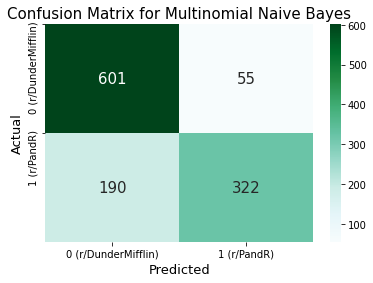

In [282]:
# get predictions for test set 
ppreds = mnb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, ppreds).ravel()
pcm = confusion_matrix(y_test, ppreds)

sns.heatmap(pcm, cmap='BuGn',fmt='g',annot=True,xticklabels=['0 (r/DunderMifflin)','1 (r/PandR)'],yticklabels=['0 (r/DunderMifflin)','1 (r/PandR)'], annot_kws={"size": 15})
plt.title("Confusion Matrix for Multinomial Naive Bayes",size=15)
plt.xlabel('Predicted',size=13)
plt.ylabel('Actual',size=13)
plt.yticks([0,1],('0 (r/DunderMifflin)','1 (r/PandR)'), fontsize="10", va="center_baseline");

In [283]:
acc = round((tp + tn)/ (tp + tn + fp + fn), 2)
miss = round(1 - acc, 2)
sens = round(tp / (tp + fn),2)
spec = round(tn / (tn + fp),2)
prec = round(tp / (tp + fp),2)
print(f'Accuracy: {acc}')
print(f'Misclassification Rate: {miss}')
print(f'Sensitivity: {sens}')
print(f'Specificity: {spec}')
print(f'Precision: {prec}')

Accuracy: 0.79
Misclassification Rate: 0.21
Sensitivity: 0.63
Specificity: 0.92
Precision: 0.85


Our Multinomial Naive Bayes model performed with 79% accuracy. Remember that a 0 in our model indicates being from the r/DunderMifflin subreddit and a 1 indicates being from the r/PandR subreddit. The sensitivity is 63% and specificity is 92% meaning that the model correctly identified a higher proportion of posts to the r/DunderMifflin subreddit than to the r/PandR subreddit.  

#### Misclassified Submissions

In [330]:
X_test_df = reddit.iloc[X_test.index] # get index from X_test
X_test_df = X_test_df.drop(columns = ['selftext','author','num_comments','score','timestamp']) # drop unnecessary rows
X_test_df.insert(1,'pred',ppreds) # add predictions

In [365]:
# get misclassified posts 
misclass_mnb = X_test_df[X_test_df['pred'] != X_test_df['subreddit']] 
misclass_mnb.head()

,title,pred,subreddit
280,Can we talk about how amazing season 2 is? It ...,0,1
197,Missing Couples Costumes,0,1
1542,"DAE think that Season 6 is becoming one of, if...",0,1
4340,Question about a song that was playing?,1,0
2865,Andy said that his parents got his name out of...,1,0


In [357]:
misclass_mnb.loc[773, 'title']

"Had great fun with this over at r/DunderMifflin yesterday, thought I would try over here- I'm nursing some broken bones for the next little while, what are some great injury-themed P/R episodes?"

The model classified the post with the above title _"Had great fun with this over at r/DunderMifflin yesterday, thought I would try over here- I'm nursing some broken bones for the next little while, what are some great injury-themed P/R episodes?"_ as being part of the r/DunderMifflin subreddit, which makes perfect sense given that r/DunderMifflin is literally in the title. Unfortunately, this post actually came from r/PandR and the user was discussing their experience on the other subreddit. 

In [363]:
misclass_mnb.loc[424, 'title']

'I\'m on season 4. Is there any "The Office" cross over or easter eggs?'

Similar to the case above, this is a submission title that includes the words "The Office." Because of this, our model classified it as belonging to the r/DunderMifflin subreddit. In reality, it is a submission from the r/PandR subreddit that mentions _The Office_. 

In [354]:
[text for text in misclass_mnb['title'] if 'Andy' in text]

['Andy said that his parents got his name out of a baby name book...',
 'How did Andy get the goldfish in the boot? S3.E3',
 "Andy's neighbor Lawrence got sweet sweet karma in Jurassic world after stealing Andy's boom box.",
 'DAE think that Andy is a 20-something Michael Scott?',
 'Does anybody else think that when Andy becomes manager, the writers just wrote his lines as though he was Michael Scott?',
 "Andy's brothers",
 'How did Andy escape budget cuts?',
 'I like Andy but I still think that Will Arnett would have been an awesome fit as boss.',
 'Andy is peter quill']

Above are all of the titles of misclassified posts that have 'Andy' in the title. We assumed 'Andy' would be in some of the misclassified posts because both shows, _The Office_ and _Parks and Recreation_ have a character named Andy. Many of the above posts mention Andy and no other identifying characters or features of the show, which is why the model had trouble determining its appropriate subreddit. One title that doesn't quite fit this logic is the one that reads _'Does anybody else think that when Andy becomes manager, the writers just wrote his lines as though he was Michael Scott?'_ Michael Scott is the main character of _The Office_ so we would assume this combination would have helped the model to determine the appropriate subreddit, but alas it did not. 

In [364]:
[text for text in misclass_mnb['title'] if 'Scott' in text]

['Adam Scott AMA - Jun 23, 5pm EDT in r/IAmA',
 'DAE think that Andy is a 20-something Michael Scott?',
 'Does anybody else think that when Andy becomes manager, the writers just wrote his lines as though he was Michael Scott?',
 'Can someone make me a .gif of Adam Scott winking?',
 "Anyone else glad that Adam Scott's character is getting more attention lately?"]

Similar to the above case, the last name Scott gave the model issues. The main character of _The Office_ is Michael Scott, but one of the main characters of _Parks and Recreation_ is played by Adam Scott. Thus, anytime the model came across the word `scott`, it had difficulty placing it in the proper subreddit. 

Many of the misclassified submissions were likely due to the generality of the titles. For example, one of the titles was _'Question about a song that was playing?'_. This title has no identifying words that would indicate it belonged to r/DunderMifflin or r/PandR. 

### Interpretable Model - _Logistic Regression_
[top](#Table-of-Contents:)

#### Confusion Matrix

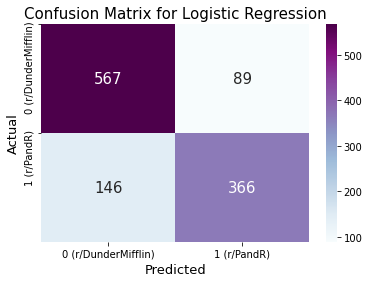

In [284]:
# get predictions for test set 
ipreds = logreg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, ipreds).ravel()
icm = confusion_matrix(y_test, ipreds)

sns.heatmap(icm, cmap='BuPu',annot=True,fmt='g',xticklabels=['0 (r/DunderMifflin)','1 (r/PandR)'],yticklabels=['0 (r/DunderMifflin)','1 (r/PandR)'], annot_kws={"size": 15})
plt.title("Confusion Matrix for Logistic Regression",size=15)
plt.xlabel('Predicted',size=13)
plt.ylabel('Actual',size=13)
plt.yticks([0,1],('0 (r/DunderMifflin)','1 (r/PandR)'), fontsize="10", va="center_baseline");

In [285]:
acc = round((tp + tn)/ (tp + tn + fp + fn), 2)
miss = round(1 - acc, 2)
sens = round(tp / (tp + fn),2)
spec = round(tn / (tn + fp),2)
prec = round(tp / (tp + fp),2)
print(f'Accuracy: {acc}')
print(f'Misclassification Rate: {miss}')
print(f'Sensitivity: {sens}')
print(f'Specificity: {spec}')
print(f'Precision: {prec}')

Accuracy: 0.8
Misclassification Rate: 0.2
Sensitivity: 0.71
Specificity: 0.86
Precision: 0.8


Our Logistic Regression model performed with 80% accuracy. The sensitivity is 71% and specificity is 86% meaning that the model correctly identified a higher proportion of posts to the r/DunderMifflin subreddit than to the r/PandR subreddit, as did the Multinomial Naive Bayes model. The difference in sensitivity and specificity is smaller for this model, though.  

#### Misclassified Submissions

In [366]:
X_test_df = reddit.iloc[X_test.index] # get index from X_test
X_test_df = X_test_df.drop(columns = ['selftext','author','num_comments','score','timestamp']) # drop unnecessary rows
X_test_df.insert(1,'pred',ipreds) # add predictions

In [394]:
# get misclassified posts 
misclass_lr = X_test_df[X_test_df['pred'] != X_test_df['subreddit']] 
misclass_lr.tail()

,title,pred,subreddit
1620,"A calzone gave me food poisoning last night,",0,1
1450,Blooper reel?,0,1
2274,Crime Reduces Innocence Makes Everyone -- Angr...,1,0
4556,Doomsday discussion thread,1,0
4490,Maybe this is really weird...,1,0


In [369]:
misclass_lr.loc[4382, 'title']

'Is it just me or does John Krasinski (Jimmy Halpert) voice a lot of commercials?'

In [372]:
misclass_lr.loc[3031, 'title']

'I think Kevin was the person who robbed the office in the Crime Aid episode.'

The submission with the title _'Is it just me or does John Krasinski (Jimmy Halpert) voice a lot of commercials?'_ was misclassified, which is surprising to me. Not only does this have a character name, but it also has the actor's name as well! John Krasinski plays one of the main characters, Jim Halpert, on _The Office_. It is interesting that this submission somehow made it into the r/PandR predictions. Similarly, the post with the title _'I think Kevin was the person who robbed the office in the Crime Aid episode.'_ was also predicted to be in r/PandR despite having a fairly popular character in the title as well as the name of the show, _The Office_. 

In [384]:
misclass_lr.loc[2144, 'title']

'R.I.P Tom'

The above submission title, _'R.I.P. Tom'_ is for a post from the r/DunderMifflin subreddit. The model misclassified it as being from the r/PandR subreddit, which makes sense because one of the main characters of _Parks and Recreation_ is named Tom. With pretty much no other words to help categorize this title, no further context could be built. 

In [393]:
misclass_lr.loc[679, 'title']

'Former Parks Director, Michael Tansley, is the one who planted the pot in the community garden.'

The submission with the title _'Former Parks Director, Michael Tansley, is the one who planted the pot in the community garden.'_ was incorrectly classified as being a part of the r/DunderMifflin subreddit. This is likely because of the name Michael in the title. None of the main characters of _Parks and Recreation_ are named Michael, so this post instead got grouped with the _The Office_ subreddit.

Many of the misclassified submissions were likely due to the generality of the titles. For example, one of the titles was _'Blooper reel?'_. This title has no identifying words that would indicate it belonged to r/DunderMifflin or r/PandR. 

#### Interpreting Coefficients

In [401]:
coefs = logreg.best_estimator_.steps[2][1].coef_ # getting coefficients
cols = logreg.best_estimator_.steps[0][1].get_feature_names() # getting column names
cols = pd.Series(cols) # turn into series
coefs = coefs[0]
feature_coefs = pd.DataFrame(coefs, index=cols) # put in data frame
top_parks_feat = feature_coefs.sort_values(0,ascending=False).head(15) # top 15 features
top_off_feat = feature_coefs.sort_values(0,ascending=False).tail(15) # 'bottom' 15 features

In our model, a value of 0 indicated belonging to the r/DunderMifflin (_The Office_) subreddit, while a value of 1 indicated belonging to the r/PandR (_Parks and Recreation_) subreddit. Thus, when looking at the coefficients, words with larger, positive coefficients would be more closely associated with the _Parks and Recreation_ subreddit, while words with smaller, negative coefficients would be more closely associated with the _The Office_ subreddit. We will look at the fetures with the 15 largest and 15 smallest coefficients.

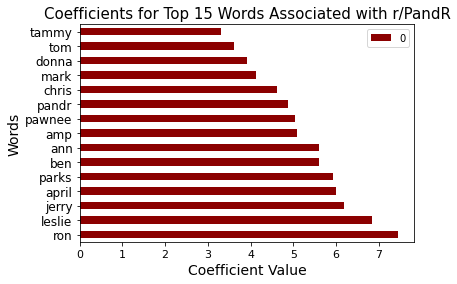

In [441]:
top_parks_feat.plot(kind='barh',color='darkred')
plt.title('Coefficients for Top 15 Words Associated with r/PandR',size=15)
plt.ylabel('Words',size=14)
plt.xlabel('Coefficient Value',size=14)
plt.yticks(size=12)
plt.xticks(size=11);

Above are the top 15 positive coefficients for the logistic regression model. When we look at the list, it makes sense. Ron, Leslie, Jerry, April, Ben, Ann, Chris, Mark, Donna, Tom, and Tammy are all main characters from _Parks and Recreation_. Pawnee is the town where _Parks and Recreation_ takes place. `PandR` is the name of the subreddit itself. Lastly, `amp` may seem odd here, but actually this makes sense as well. Often, people write the name of the show as _Parks & Rec_, using an ampersand. In HTML, the `&` sign is read as `&amp;`. So when we read in this data from reddit, it pulled in `&amp;` as opposed to `&` and our model cleaned the non-alphanumeric symbols from the word, leaving only `amp`. 

In [402]:
top_parks_feat

,0
ron,7.455006
leslie,6.825718
jerry,6.185149
april,5.992854
parks,5.930971
ben,5.597879
ann,5.587543
amp,5.076798
pawnee,5.028507
pandr,4.879771


In [410]:
# ron
np.exp(7.455006)

1728.494366202519

In [411]:
# pawnee
np.exp(5.028507)

152.7048540704553

In [412]:
# tammy
np.exp(3.317171)

27.58221000870921

In our model, for every 1 unit increase in the frequency of the word `ron` in the submission title, that submission was 1728.5 times as likely to belong to the r/PandR subreddit, all else held equal.

In our model, for every 1 unit increase in the frequency of the word `pawnee` in the submission title, that submission was 152.7 times as likely to belong to the r/PandR subreddit, all else held equal.

In our model, for every 1 unit increase in the frequency of the word `tammy` in the submission title, that submission was 27.6 times as likely to belong to the r/PandR subreddit, all else held equal.


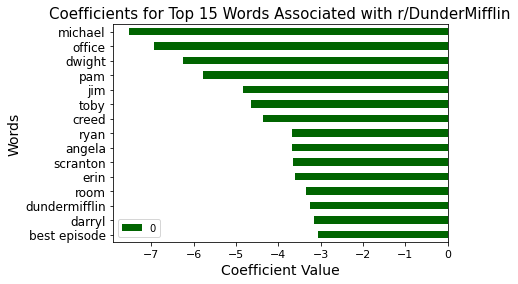

In [444]:
top_off_feat.plot(kind='barh',color='darkgreen')
plt.title('Coefficients for Top 15 Words Associated with r/DunderMifflin',size=15)
plt.ylabel('Words',size=14)
plt.xlabel('Coefficient Value',size=14)
plt.yticks(size=12)
plt.xticks(size=11);

Above are the 15 strongest negative coefficients for the logistic regression model. For the most part, this list makes sense. Michael, Dwight, Pam, Jim, Toby, Creed, Ryan, Angela, Erin, and Darryl are all main characters on the show _The Office_. Scranton is where _The Office_ takes place. The word `office` makes sense, as it is in the name of the show. `dundermifflin` is not only the name of the subreddit we are discussing, but it is also the name of the paper company that _The Office_ focuses on. It isn't exactly clear why `room` is an indicator of being a part of the r/DunderMifflin subreddit, but we can assume it might have something to do with _the conference room_ and the fact that Michael is always hosting strange meetings in there. This might pop up in some submissions then. Lastly, `best episode` is an interesting feature. This could obviously apply to either show/subreddit, but apparently was discussed more in the r/DunderMifflin subreddit. 

In [413]:
top_off_feat

,0
best episode,-3.070436
darryl,-3.158133
dundermifflin,-3.240538
room,-3.349333
erin,-3.596560
scranton,-3.662051
angela,-3.673531
ryan,-3.685674
creed,-4.368170
toby,-4.639908


In [417]:
# michael
(np.exp(-7.531737) - 1) * 100

-99.94641932484201

In [418]:
# creed
(np.exp(-4.368170) - 1) * 100

-98.73255864649573

In [419]:
# darryl
(np.exp(-3.158133) - 1) * 100

-95.74949760733841

In our model, for every 1 unit increase in the frequency of the word `michael` in the submission title, that submission was 99.9% less likely to belong to the r/PandR subreddit, all else held equal.

In our model, for every 1 unit increase in the frequency of the word `creed` in the submission title, that submission was 98.7% less likely to belong to the r/PandR subreddit, all else held equal.

In our model, for every 1 unit increase in the frequency of the word `darryl` in the submission title, that submission was 95.7% less likely to belong to the r/PandR subreddit, all else held equal.

## Conclusions & Recommendations
[top](#Table-of-Contents:)

Our models are not perfect, but they are accurately classifying almost 80% of the data  
Words that reference people and places from the TV shows are the best indicators for what subreddit a submission belongs in  
Not a foolproof rule:  
Because these shows are so similar, they have an overlapping fan base that often compare the two and mention each other in posts  
Our models classified the r/DunderMifflin subreddit better, so we can look deeper for better indicators of the r/PandR subreddit and look for more stop words


## References
[Top](#Table-of-Contents:)  

https://www.reddit.com/r/DunderMifflin/  
https://www.reddit.com/r/PandR/

[knn?](https://iq.opengenus.org/text-classification-using-k-nearest-neighbors/)  

[more knn?](https://www.researchgate.net/publication/326893075_Text_Classification_using_KNN_with_different_Feature_Selection_Methods)

“The Office.” IMDb, IMDb.com, 24 Mar. 2005, www.imdb.com/title/tt0386676/.  

“Parks and Recreation.” IMDb, IMDb.com, 9 Apr. 2009, www.imdb.com/title/tt1266020/.  

Pushshift.io. “Pushshift Reddit API Documentation.” GitHub, 1 Oct. 2019, github.com/pushshift/api.  

“r/DunderMifflin: People Person's Paper People.” Reddit, www.reddit.com/r/DunderMifflin/.  

“r/PandR: Tommy's Place.” Reddit, www.reddit.com/r/PandR/.   

“r/Reddit.com.” Reddit, www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F.